# 02 - Data from the Web

In [1]:
# Needed imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import difflib
import seaborn as sns
import numpy as np
%matplotlib inline

## Some helper functions we need

These functions will be used throughout the homework.

In [2]:
# Parses a string to an integer, removing invalid characters
def parseInt(numStr):
    cleaned = [x for x in numStr if x.isdigit()]
    return int("".join(cleaned))

# Parses a string to a float, removing invalid characters
def parseDecimal(numStr):
    cleaned = [x for x in numStr if x.isdigit() or x == '.']
    return float("".join(cleaned))

## Task 1


### a. Load data
- Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). We can obtain this information by parsing the JSON file from the QS website.

In [3]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt')
qs_dataset = r.json()['data']

In [4]:
# Sample record
qs_dataset[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

- For each university, we extract: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Since the detailed information (faculty and students) is not avaiable in the main JSON file, we gather it from the respective page of each university by parsing the HTML content.
 - Note: the values of students and faculty members may be missing in the details page. In this case, we set them to 0.

In [5]:
results = []
for university in qs_dataset[:200]:
    url = 'https://www.topuniversities.com' + university['url']
    details_html = requests.get(url)
    soup = BeautifulSoup(details_html.text, 'html.parser')

    def parseAttribute(className):
        attr = soup.find('div', class_=className)
        if attr is not None:
            return parseInt(attr.find('div', class_='number').text)
        else:
            return 0 # Missing value
        
    results.append({
            'name': university['title'],
            'rank': parseInt(university['rank_display']),
            'country': university['country'],
            'region': university['region'],
            'faculty_international': parseAttribute('inter faculty'),
            'faculty_total': parseAttribute('total faculty'),
            'students_international': parseAttribute('total inter'),
            'students_total': parseAttribute('total student')
        })

- Convert the resulting dataset into a DataFrame and store it as a file (for reusing it later without parsing the content again).

In [6]:
qs_df = pd.DataFrame.from_dict(results).set_index('name')
qs_df.to_pickle('qs_dataset')

In [7]:
qs_df = pd.read_pickle('qs_dataset')
qs_df.head() # Show first elements

,country,faculty_international,faculty_total,rank,region,students_international,students_total
name,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679,2982,1,North America,3717,11067
Stanford University,United States,2042,4285,2,North America,3611,15878
Harvard University,United States,1311,4350,3,North America,5266,22429
California Institute of Technology (Caltech),United States,350,953,4,North America,647,2255
University of Cambridge,United Kingdom,2278,5490,5,Europe,6699,18770


### Remarks
- There is no university with rank #198. As a result, the interval of the ranking is [1,201]. This is an error in the QS ranking.

### b. Add the columns 'faculty_students_ratio' and 'international_ratio'

**'faculty_students_ratio'** represents the faculty-to-students ratio.

**'international_ratio'** represents the fraction of international students. 

In [8]:
qs_df['faculty_students_ratio'] = qs_df['faculty_total']/qs_df['students_total']
qs_df['international_ratio'] = qs_df['students_international']/qs_df['students_total']
# For this analysis, we keep only the columns in which we are interested
qs_df_analysis = qs_df.loc[:, ['region', 'country','rank', 'faculty_students_ratio', 'international_ratio']]
qs_df_analysis.head()

,region,country,rank,faculty_students_ratio,international_ratio
name,,,,,
Massachusetts Institute of Technology (MIT),North America,United States,1,0.269450,0.335863
Stanford University,North America,United States,2,0.269870,0.227422
Harvard University,North America,United States,3,0.193945,0.234785
California Institute of Technology (Caltech),North America,United States,4,0.422616,0.286918
University of Cambridge,Europe,United Kingdom,5,0.292488,0.356899


### c. Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- By sorting along these columns we can respectively find the best universities in terms of (a) ratio between faculty members and students and (b) ratio of international students.

In [9]:
sorted_ = qs_df_analysis.sort_values('faculty_students_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # Start from index = 1
sorted_.head()

,name,region,country,rank,faculty_students_ratio,international_ratio
1,California Institute of Technology (Caltech),North America,United States,4,0.422616,0.286918
2,Yale University,North America,United States,16,0.398323,0.199081
3,University of Oxford,Europe,United Kingdom,6,0.342292,0.372870
4,University of Cambridge,Europe,United Kingdom,5,0.292488,0.356899
5,Johns Hopkins University,North America,United States,17,0.276353,0.254243


Caltech is the university with the highest faculty/students ratio. It also appears that the best universities in this group are in the top 20 of the QS ranking.

In [10]:
sorted_ = qs_df_analysis.sort_values('international_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # Start from index = 1
sorted_.head()

,name,region,country,rank,faculty_students_ratio,international_ratio
1,London School of Economics and Political Scien...,Europe,United Kingdom,35,0.111475,0.691393
2,Ecole Polytechnique Fédérale de Lausanne (EPFL),Europe,Switzerland,12,0.163879,0.570047
3,Imperial College London,Europe,United Kingdom,8,0.244251,0.543567
4,Maastricht University,Europe,Netherlands,200,0.077937,0.502533
5,Carnegie Mellon University,North America,United States,47,0.100479,0.478062


The London School of Economics and Political Science is the most international university, followed by EPFL.

### d. Answer the previous question aggregating the data by (c) country and (d) region.
- We answer the same question aggregating the data by (c) **country** and (d) **region**. For each group, we show the average of the students-to-faculty ratio and international students ratio. Note that every table reports the mean, the standard error of the mean (which is reported in the bar plot as the confidence line), and the count (number of universities in top 200). These statistics will come handy in our observations.

In [11]:
# We define a helper function for aggregating the data and drawing the graph.
# This function will be used for the analysis of both QS and THE datasets.
# In our case, 'grouping_col' will be either 'country' or 'region,
# and 'value_col' will be either 'faculty_students_ratio' or 'international_ratio'.
def aggregate_analyze(df, grouping_col, value_col, title=""):
    '''
    Arguments:
    -- df: the DataFrame to process
    -- grouping_col: the column by which the data will be grouped
    -- value_col: the variabile to average within each group
    '''

    grouped = df.groupby([grouping_col]).agg({value_col: ['mean', 'sem', 'count']})\
        .sort_values([(value_col, 'mean')], ascending=False)
    
    grouped_with_rank = grouped.reset_index().fillna('-')
    grouped_with_rank.index = range(1, len(grouped) + 1) # Start from index = 1
    
    # Plot
    ax = grouped[(value_col, 'mean')].plot.bar(title = title, figsize=(10,5), yerr=grouped[(value_col, 'sem')])
    #ax.legend_.remove()
    ax.set_ylabel(value_col.replace('_', ' ').capitalize())
    ax.set_xlabel(grouping_col.replace('_', ' ').capitalize())
    
    return grouped_with_rank

country faculty_students_ratio                   
                                     mean          sem count
1           Russia               0.221910            -     1
2          Denmark               0.186580     0.049161     3
3     Saudi Arabia               0.175828            -     1
4        Singapore               0.162279   0.00626568     2
5            Japan               0.155840    0.0079886     9
6         Malaysia               0.153893            -     1
7    United States               0.151151     0.012881    46
8      South Korea               0.149356    0.0109565     7
9           France               0.144006    0.0237205     5
10          Israel               0.136047            -     1
11  United Kingdom               0.135913    0.0116629    28
12     Switzerland               0.134872    0.0145765     7
13       Argentina               0.134267            -     1
14       Hong Kong               0.128988    0.0077907     5
15          Norway               0.122510    0.0192761     2
16          Mexico               0.121204    0.0150103     2
17           China               0.116318    0.0100078     7
18         Finland               0.110731   0.00724897     2
19     Netherlands               0.105311   0.00903764    10
20          Sweden               0.104255   0.00765182     5
21          Canada               0.103298    0.0124974     7
22           Italy               0.100247    0.0324242     4
23         Germany               0.098542    0.0109579    11
24         Belgium               0.092131    0.0338928     4
25    South Africa               0.088450            -     1
26           India               0.086467    0.0124628     3
27           Spain               0.085209    0.0100949     3
28         Ireland               0.082180   0.00130421     2
29          Taiwan               0.080311   0.00687666     2
30          Brazil               0.079505    0.0054424     2
31       Australia               0.076407   0.00551508     9
32           Chile               0.070883     0.012811     2
33     New Zealand               0.068687  0.000372741     2
34         Austria               0.057298     0.016907     2

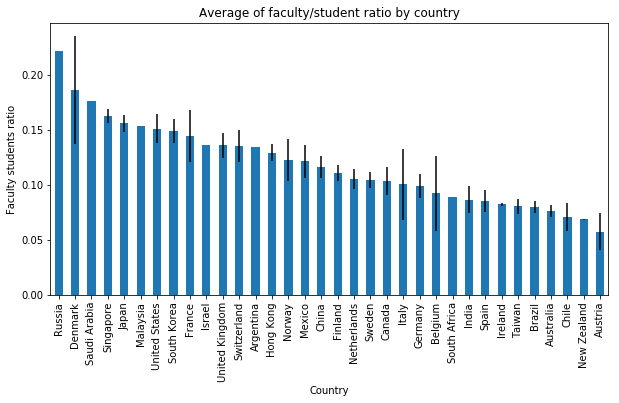

In [12]:
aggregate_analyze(qs_df_analysis, 'country', 'faculty_students_ratio', title="Average of faculty/student ratio by country")

country international_ratio                   
                                  mean          sem count
1   United Kingdom            0.351308    0.0192302    28
2        Australia            0.346878    0.0186957     9
3      Switzerland            0.313816    0.0541205     7
4        Hong Kong            0.312148    0.0296176     5
5          Austria            0.306095   0.00865245     2
6        Singapore            0.277091   0.00463284     2
7           Canada            0.252604    0.0218476     7
8      New Zealand            0.248971    0.0400886     2
9      Netherlands            0.245456    0.0400937    10
10         Ireland            0.241791    0.0463587     2
11       Argentina            0.221658            -     1
12          France            0.213286    0.0358101     5
13   United States            0.194802    0.0117607    46
14        Malaysia            0.194168            -     1
15    South Africa            0.169703            -     1
16          Russia            0.168624            -     1
17          Sweden            0.167998    0.0236584     5
18         Germany            0.165300   0.00748241    11
19         Denmark            0.164809    0.0367052     3
20    Saudi Arabia            0.163742            -     1
21         Belgium            0.160108    0.0209475     4
22           Spain            0.121967   0.00614381     3
23           Italy            0.120418    0.0251049     4
24          Norway            0.111379    0.0395017     2
25           China            0.107560     0.017846     7
26         Finland            0.102890    0.0478471     2
27     South Korea            0.102453    0.0157317     7
28          Taiwan            0.091680   0.00622312     2
29           Japan            0.090000   0.00427166     9
30          Israel            0.062549            -     1
31          Mexico            0.060436    0.0451264     2
32           Chile            0.045816   0.00911621     2
33          Brazil            0.034050    0.0023045     2
34           India            0.010712  0.000477384     3

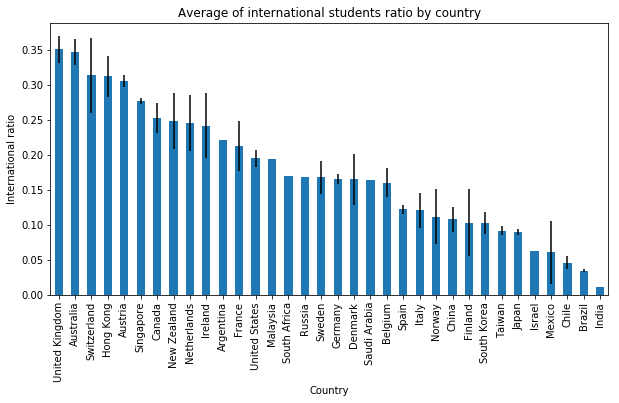

In [13]:
aggregate_analyze(qs_df_analysis, 'country', 'international_ratio', title="Average of international students ratio by country")

region faculty_students_ratio                  
                                   mean         sem count
1  North America               0.144831   0.0114913    53
2           Asia               0.134673  0.00537992    38
3         Europe               0.120003  0.00565602    89
4  Latin America               0.096779   0.0113121     7
5         Africa               0.088450           -     1
6        Oceania               0.075003  0.00456046    11

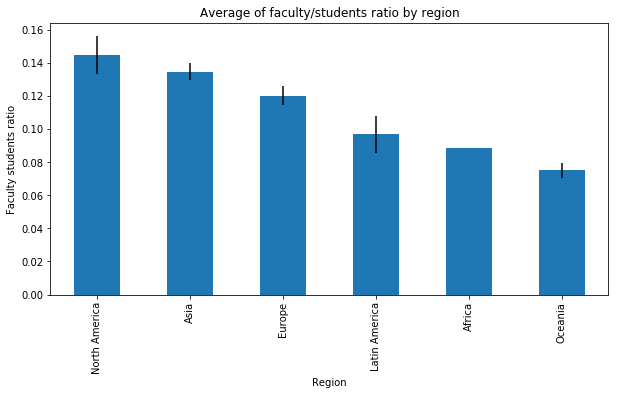

In [14]:
aggregate_analyze(qs_df_analysis, 'region', 'faculty_students_ratio', title="Average of faculty/students ratio by region")

region international_ratio                 
                                mean        sem count
1        Oceania            0.329077   0.020015    11
2         Europe            0.245932  0.0129953    89
3  North America            0.202437   0.010887    53
4         Africa            0.169703          -     1
5           Asia            0.132394  0.0153286    38
6  Latin America            0.071751  0.0272405     7

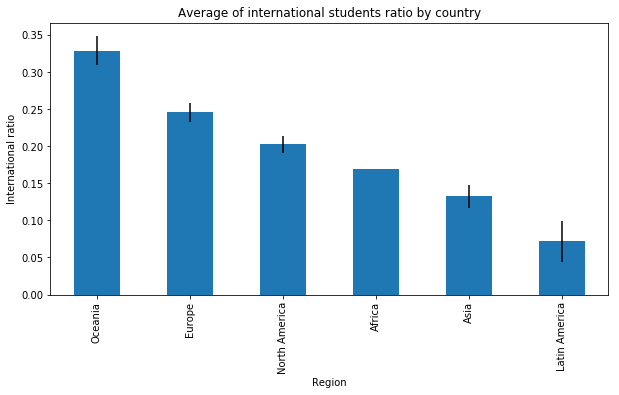

In [15]:
aggregate_analyze(qs_df_analysis, 'region', 'international_ratio', title="Average of international students ratio by country")

### Remarks
In our opinion, there is some bias in these statistics. As can be seen from the confidence metrics, some countries/regions have very few universities in the top 200, and therefore the sample size is not big enough for obtaining a reliable result. For example, Russia is reportedly the state with the highest student/faculty ratio (0.22), but there is only one university from Russia. Hence, this result is not very meaningful.

## Task 2
We now obtain the 200 top-ranking universities from www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)) and repeat the previous analysis. Similarly as before, we found a JSON file that contains the list of universities in the main web page.

In [16]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
the_dataset = r.json()['data']

In [17]:
the_dataset[0] # Show an example

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

There are some small differences between the QS and THE datasets, and we need to align their variables as best as possible.
- THE reports the inverse of the faculty-to-students ratio.
- Only the percentage of international students is provided. We can easily compute the absolute number by multiplying it with the total number of students.
- The number of faculty members is not provided. We can compute it from the faculty/students ratio.
- There is no information about the number/percentage of international faculty. We cannot infer this data.
- The region is not given, but we can compute it easily by matching each country with the QS dataset.

In [18]:
results = []
for university in the_dataset[:200]:
    results.append({
            'name': university['name'],
            'rank': parseInt(university['rank']),
            'country': university['location'],
            'faculty_students_ratio': 1 / parseDecimal(university['stats_student_staff_ratio']),
            'international_ratio': parseDecimal(university['stats_pc_intl_students']) / 100,
            'students_total': parseInt(university['stats_number_students'])
        })

the_df = pd.DataFrame.from_dict(results).set_index('name')

# Compute derived attributes (where applicable)
the_df['students_international'] = (the_df['students_total'] * the_df['international_ratio']).astype('int')
the_df['faculty_total'] = (the_df['students_total'] * the_df['faculty_students_ratio']).astype('int')

In [19]:
# Map countries to regions using the QS dataset
mapping = qs_df[['country', 'region']].set_index('country').to_dict()['region']

# Manually add missing mappings that are not present in the QS dataset
mapping['Luxembourg'] = 'Europe'
mapping['Russian Federation'] = 'Europe'

the_df['region'] = the_df['country'].replace(mapping)
the_df['country'].replace({'Russian Federation': 'Russia'}, inplace=True)

# For this analysis keep only the columns in which we are interested
the_df_analysis = the_df.loc[:, ['region', 'rank', 'country', 'faculty_students_ratio', 'international_ratio']]
the_df_analysis.head()

,region,rank,country,faculty_students_ratio,international_ratio
name,,,,,
University of Oxford,Europe,1,United Kingdom,0.089286,0.38
University of Cambridge,Europe,2,United Kingdom,0.091743,0.35
California Institute of Technology,North America,3,United States,0.153846,0.27
Stanford University,North America,3,United States,0.133333,0.22
Massachusetts Institute of Technology,North America,5,United States,0.114943,0.34


### Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- As before, by sorting along these columns we can respectively find the best universities in terms of (a) ratio between faculty members and students and (b) ratio of international students.

In [20]:
sorted_ = the_df_analysis.sort_values('faculty_students_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # start index from 1
sorted_.head()

,name,region,rank,country,faculty_students_ratio,international_ratio
1,Vanderbilt University,North America,105,United States,0.303030,0.13
2,University of Copenhagen,Europe,109,Denmark,0.243902,0.14
3,University of Rochester,North America,153,United States,0.232558,0.29
4,Yale University,North America,12,United States,0.232558,0.21
5,Johns Hopkins University,North America,13,United States,0.232558,0.24


In [21]:
sorted_ = the_df_analysis.sort_values('international_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # start index from 1
sorted_.head()

,name,region,rank,country,faculty_students_ratio,international_ratio
1,London School of Economics and Political Science,Europe,25,United Kingdom,0.081967,0.71
2,University of Luxembourg,Europe,179,Luxembourg,0.068493,0.57
3,École Polytechnique Fédérale de Lausanne,Europe,38,Switzerland,0.089286,0.55
4,Imperial College London,Europe,8,United Kingdom,0.087719,0.55
5,Maastricht University,Europe,103,Netherlands,0.055556,0.50


### Answer the previous question aggregating the data by (c) country and (d) region.
- We answer the same question aggregating the data by (c) **country** and (d) **region**. As before, for each group, we show the average of the students-to-faculty ratio and international students ratio, as well as the standard error of the mean and count within each group.

country faculty_students_ratio                  
                                     mean         sem count
1          Denmark               0.160166   0.0503266     3
2            Italy               0.138889   0.0534188     2
3           Russia               0.136986           -     1
4            Japan               0.132098   0.0171556     2
5    United States               0.106390  0.00726332    62
6           France               0.099352   0.0226036     6
7            China               0.087420  0.00794675     7
8           Taiwan               0.086957           -     1
9     South Africa               0.085470           -     1
10     Switzerland               0.083447   0.0148839     7
11     South Korea               0.080220   0.0104347     4
12  United Kingdom               0.074252  0.00165151    31
13          Sweden               0.072475  0.00929387     6
14      Luxembourg               0.068493           -     1
15           Spain               0.062798   0.0147212     2
16       Singapore               0.060087  0.00126308     2
17       Hong Kong               0.056622  0.00901496     5
18     Netherlands               0.056504  0.00327928    13
19         Finland               0.055617  0.00611172     2
20          Norway               0.053763           -     1
21     New Zealand               0.053191           -     1
22          Canada               0.052726  0.00500842     6
23         Austria               0.048077           -     1
24         Ireland               0.043860           -     1
25       Australia               0.038233  0.00318752     8
26         Germany               0.027957  0.00329589    20
27         Belgium               0.026076  0.00105232     4

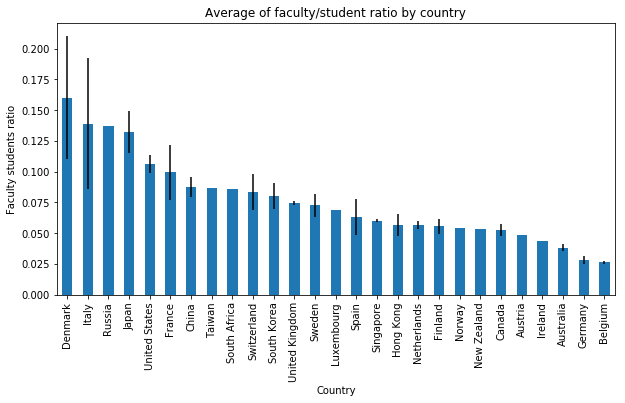

In [22]:
aggregate_analyze(the_df_analysis, 'country', 'faculty_students_ratio', title="Average of faculty/student ratio by country")

country international_ratio                  
                                  mean         sem count
1       Luxembourg            0.570000           -     1
2   United Kingdom            0.365484   0.0175844    31
3        Hong Kong            0.328000       0.028     5
4      Switzerland            0.314286    0.051955     7
5        Australia            0.307500    0.018969     8
6        Singapore            0.305000       0.005     2
7      New Zealand            0.290000           -     1
8          Ireland            0.270000           -     1
9          Austria            0.260000           -     1
10          Canada            0.225000   0.0226201     6
11          Russia            0.220000           -     1
12          France            0.208333   0.0349682     6
13         Belgium            0.197500    0.054064     4
14     Netherlands            0.192308   0.0327021    13
15          Norway            0.190000           -     1
16   United States            0.181774   0.0097822    62
17    South Africa            0.180000           -     1
18         Denmark            0.166667   0.0371184     3
19         Germany            0.152000  0.00939205    20
20           Spain            0.140000        0.02     2
21          Sweden            0.140000   0.0167332     6
22         Finland            0.130000        0.07     2
23           Italy            0.105000       0.035     2
24           Japan            0.090000        0.01     2
25     South Korea            0.090000   0.0177951     4
26           China            0.085714   0.0157143     7
27          Taiwan            0.080000           -     1

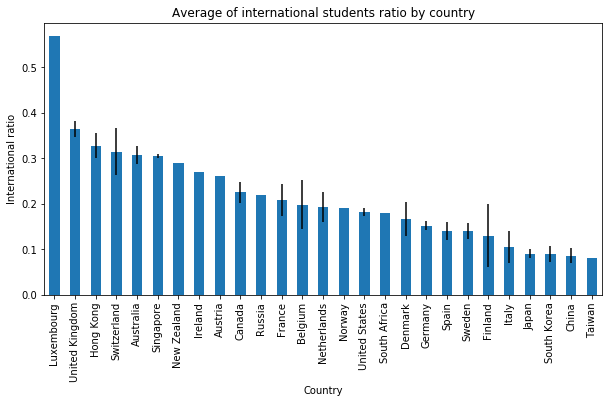

In [23]:
aggregate_analyze(the_df_analysis, 'country', 'international_ratio', title="Average of international students ratio by country")

region faculty_students_ratio                  
                                   mean         sem count
1  North America               0.101655  0.00688596    68
2         Africa               0.085470           -     1
3           Asia               0.080345  0.00608702    21
4         Europe               0.065952  0.00382956   101
5        Oceania               0.039895  0.00326569     9

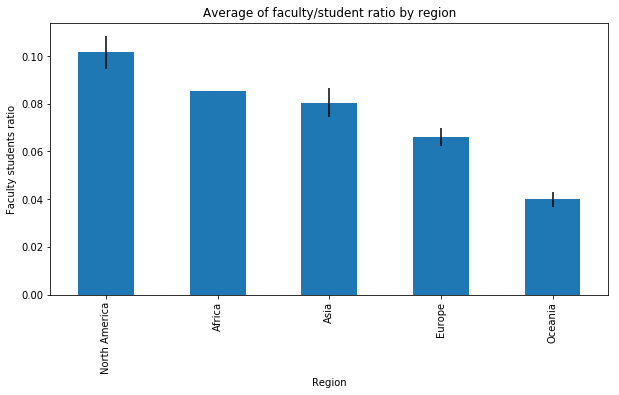

In [24]:
aggregate_analyze(the_df_analysis, 'region', 'faculty_students_ratio', title="Average of faculty/student ratio by region")

region international_ratio                  
                                mean         sem count
1        Oceania            0.305556   0.0168417     9
2         Europe            0.244653   0.0129543   101
3  North America            0.185588  0.00922212    68
4         Africa            0.180000           -     1
5           Asia            0.165238   0.0261463    21

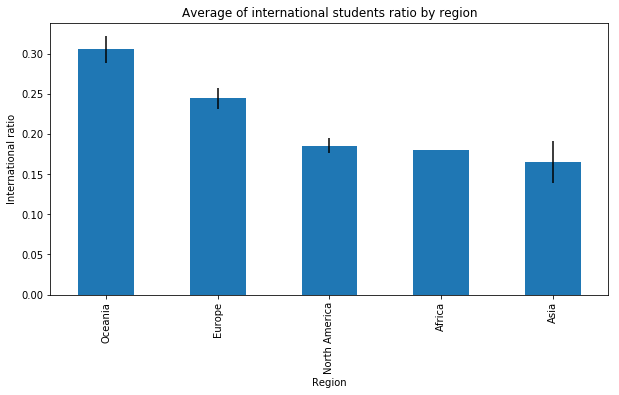

In [25]:
aggregate_analyze(the_df_analysis, 'region', 'international_ratio', title="Average of international students ratio by region")

### Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.
We implemented a fuzzy join algorithm for merging the two rankings. Since the names of the universities may differ slightly, it is necessary to use a string matching algorithm based on a similarity score.
Our algorithm works as follows:
- For each university in the first ranking (QS), we find the corresponding university in the second ranking (THE) that minimizes the edit distance between the two strings. There are several metrics that could be used: we used the one that is implemented in Python's difflib (a variant of the Ratcliff-Obershelp algorithm). Other choices are possible (e.g. Levenshtein distance). The match is accepted only if all these conditions are true:
 - The countries of the two matches correspond.
 - The edit distance is below a certain threshold.
 - If we match university A to university B, the match in the opposite direction is consistent (i.e. we match B to A).
 
Of course, it is not possible to match all universities. Some universities that are present in the QS ranking may not be present in the THE ranking, and vice versa.

In [26]:
not_matched_counter = 0

qs_df_ = qs_df.copy().reset_index()
the_df_ = the_df.copy().reset_index()

mapping = qs_df_['name'].copy()
for i in range(len(qs_df_)):
    def match():
        tolerance = 0.6 # Threshold that regulates the sensitivity of the algorithm
        res = difflib.get_close_matches(qs_df_['name'][i], the_df_['name'], 1, tolerance)
        if len(res) > 0:
            matching_country = the_df_['country'][the_df_['name'] == res[0]]
            if len(matching_country) == 1 and matching_country.values[0] == qs_df_['country'][i]:
                back_res = difflib.get_close_matches(res[0], qs_df_['name'], 1, tolerance)
                if len(back_res) > 0 and qs_df_['name'][i] == back_res[0]:
                    mapping[i] = res[0]
                    return True
        return False
    if not match():
        not_matched_counter += 1

qs_df_['name'] = mapping
print(not_matched_counter, 'universities were not matched.')
merged_df = qs_df_.merge(the_df_, on='name', how='inner', suffixes=('_qs', '_the'))

# Clean the table (only one column for the region and the country)
merged_df["region"] = merged_df.region_qs
merged_df["country"] = merged_df.country_qs
merged_df.drop(['region_qs', 'region_the', 'country_qs', 'country_the'], axis = 1, inplace = True)

50 universities were not matched.


In [27]:
# Represent the columns in a cleaner way
cleaned = merged_df.copy()[['name', 'country', 'region', 'faculty_international', 'rank_qs', 'rank_the', "faculty_total_qs", "faculty_total_the",\
  'faculty_students_ratio_qs', 'faculty_students_ratio_the', 'international_ratio_qs', 'international_ratio_the',\
       'students_international_qs', 'students_international_the', 'students_total_qs', 'students_total_the']]
col_level1 = ['', 'rank', 'faculty_total', 'faculty_students_ratio', 'international_ratio', 'students_international', 'students_total']
col_level2 = ['name', 'country', 'region', 'faculty_international_qs'] + ["qs", "the"]*(len(col_level1)-1)#done
labels_lvl1 = [0, 0, 0, 0] + [e for e in range(1, len(col_level1)) for _ in (0, 1)]
labels_lvl2 = range(len(col_level2))
cleaned.columns \
    = pd.MultiIndex(levels=[col_level1, col_level2], labels=[labels_lvl1, labels_lvl2])
cleaned = cleaned.set_index(('','name'))
cleaned.index.name = 'name'
cleaned.head()

\
                                              country         region   
name                                                                   
Massachusetts Institute of Technology   United States  North America   
Stanford University                     United States  North America   
Harvard University                      United States  North America   
California Institute of Technology      United States  North America   
University of Cambridge                United Kingdom         Europe   

                                                               rank      \
                                      faculty_international_qs   qs the   
name                                                                      
Massachusetts Institute of Technology                     1679    1   5   
Stanford University                                       2042    2   3   
Harvard University                                        1311    3   6   
California Institute of Technology                         350    4   3   
University of Cambridge                                   2278    5   2   

                                      faculty_total        \
                                                 qs   the   
name                                                        
Massachusetts Institute of Technology          2982  1284   
Stanford University                            4285  2112   
Harvard University                             4350  2283   
California Institute of Technology              953   339   
University of Cambridge                        5490  1687   

                                      faculty_students_ratio            \
                                                          qs       the   
name                                                                     
Massachusetts Institute of Technology               0.269450  0.114943   
Stanford University                                 0.269870  0.133333   
Harvard University                                  0.193945  0.112360   
California Institute of Technology                  0.422616  0.153846   
University of Cambridge                             0.292488  0.091743   

                                      international_ratio        \
                                                       qs   the   
name                                                              
Massachusetts Institute of Technology            0.335863  0.34   
Stanford University                              0.227422  0.22   
Harvard University                               0.234785  0.26   
California Institute of Technology               0.286918  0.27   
University of Cambridge                          0.356899  0.35   

                                      students_international        \
                                                          qs   the   
name                                                                 
Massachusetts Institute of Technology                   3717  3800   
Stanford University                                     3611  3485   
Harvard University                                      5266  5284   
California Institute of Technology                       647   596   
University of Cambridge                                 6699  6436   

                                      students_total         
                                                  qs    the  
name                                                         
Massachusetts Institute of Technology          11067  11177  
Stanford University                            15878  15845  
Harvard University                             22429  20326  
California Institute of Technology              2255   2209  
University of Cambridge                        18770  18389

### Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?
We start by correlating the related variables of the two rankings (e.g. QS rank with THE rank, QS faculty with THE faculty). This allows us to see if the two rankings are consistent, or if they have significant differences.

In [28]:
cols_qs = merged_df[['rank_qs', 'faculty_total_qs', 'students_international_qs',
                  'students_total_qs', 'faculty_students_ratio_qs', 'international_ratio_qs']]
cols_the = merged_df[['rank_the', 'faculty_total_the', 'students_international_the',
                  'students_total_the', 'faculty_students_ratio_the', 'international_ratio_the']]
cols_qs.columns = cols_qs.columns.map(lambda x: x.rstrip('_qs'))
cols_the.columns = cols_the.columns.map(lambda x: x.rstrip('_the'))
corr = pd.DataFrame(cols_qs.corrwith(cols_the))
corr.index.name = 'Variable'
corr.columns = ['Correlation']
corr

,Correlation
Variable,
rank,0.696923
faculty_total,0.699948
students_international,0.890048
students_total,0.945166
faculty_students_ratio,0.712206
international_ratio,0.953665


We can see that the variables have a moderate correlation, but not a very strong one (except for *de facto* variables such as the number of students). This means that the two rankings use different criteria for evaluating a university.

In order to discover further information, we plot the full correlation matrix of our merged table.

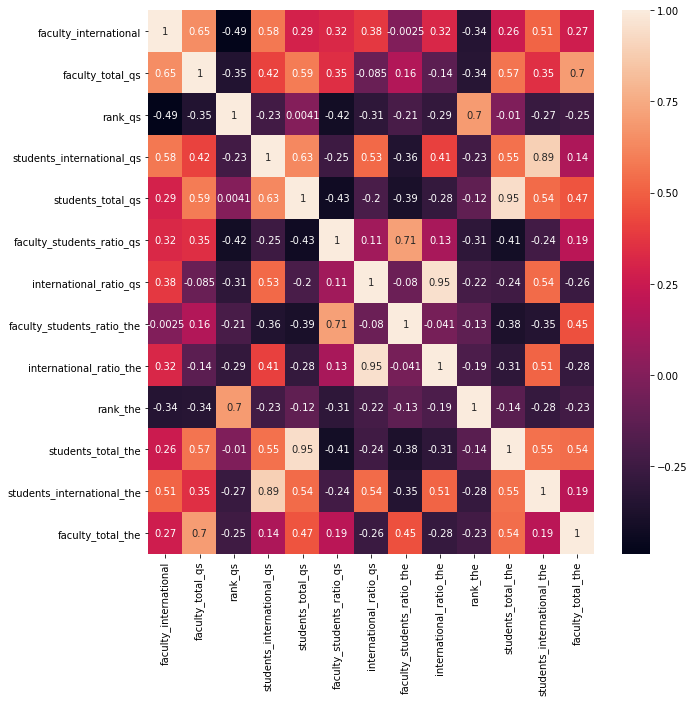

In [29]:
corr = merged_df.corr()
plt.figure(figsize=(10,10))
_ = sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [30]:
# Show the variables with the highest absolute correlation
corr_pairs = abs(corr).unstack().reset_index()
corr_pairs.columns = [['var1', 'var2', 'corr']]
corr_pairs = corr_pairs[corr_pairs['var1'] > corr_pairs['var2']] # Remove redundant entries
corr_pairs.sort_values('corr', ascending=False).head(10)

,var1,var2,corr
110,international_ratio_the,international_ratio_qs,0.953665
134,students_total_the,students_total_qs,0.945166
146,students_international_the,students_international_qs,0.890048
96,faculty_students_ratio_the,faculty_students_ratio_qs,0.712206
157,faculty_total_the,faculty_total_qs,0.699948
119,rank_the,rank_qs,0.696923
13,faculty_total_qs,faculty_international,0.647385
55,students_total_qs,students_international_qs,0.631925
53,students_total_qs,faculty_total_qs,0.589004
39,students_international_qs,faculty_international,0.578144


We cannot find significant correlations between variables, apart from obvious ones. However, it seems that the QS rank is slightly correlated with the number of international faculty (0.49) and with the faculty/students ratio (0.42). This observation is not reflected in the THE ranking.

### Can you find the best university taking in consideration both rankings? Explain your approach.
We decided to take into account only the ranks for our analysis, for these reasons:
- The rank is a summarized indicator of all the other variables that could be taken into consideration for determining the best university, including those that are not visible in our dataset.
- If we used multiple variables, it would be difficult to determine which weights assign to each of them. In this case, we would create our own ranking, with arbitrary criteria.

As a first approach, we try to use to so-called Skyline operator, which is based on comparisons between pairs of tuples. The Skyline operator compares all pairs of tuples and removes those that are dominated by others (i.e. are worse). The criterion for exclusion is based on Pareto optimality: a tuple is better than another if it is < in a variable and <= in all other variables. This approach is useful because it does not assign weights to fields (all variables are treated equal), but it is not guaranteed to return a single result.

In [31]:
def dominates(t1, t2):
    if t1['rank_qs'] <= t2['rank_qs'] and t1['rank_the'] < t2['rank_the']:
        return True
    if t1['rank_qs'] < t2['rank_qs'] and t1['rank_the'] <= t2['rank_the']:
        return True
    return False

df = merged_df.copy()
dominates_all = np.ones(len(df), dtype=bool) # True if the i-th tuple dominates all other tuples
for i, t1 in df.iterrows():
    if dominates_all[i]:
        for j, t2 in df.iterrows():
            if dominates(t1, t2):
                dominates_all[j] = False
            
best_universities = df.loc[dominates_all]
best_universities

,name,faculty_international,faculty_total_qs,rank_qs,students_international_qs,students_total_qs,faculty_students_ratio_qs,international_ratio_qs,faculty_students_ratio_the,international_ratio_the,rank_the,students_total_the,students_international_the,faculty_total_the,region,country
0,Massachusetts Institute of Technology,1679,2982,1,3717,11067,0.269450,0.335863,0.114943,0.34,5,11177,3800,1284,North America,United States
1,Stanford University,2042,4285,2,3611,15878,0.269870,0.227422,0.133333,0.22,3,15845,3485,2112,North America,United States
4,University of Cambridge,2278,5490,5,6699,18770,0.292488,0.356899,0.091743,0.35,2,18389,6436,1687,Europe,United Kingdom
5,University of Oxford,2964,6750,6,7353,19720,0.342292,0.372870,0.089286,0.38,1,20409,7755,1822,Europe,United Kingdom


According to the Skyline operator, the above 4 universities are equivalent, as they are incomparable among each other (one of them is better in the QS ranking, and the other is better in the THE ranking).

In order to resolve ties, we decided to adopt the simplest approach: we sum the two ranks and select the university with the lowest sum.

In [32]:
rankings = best_universities[['name', 'rank_qs', 'rank_the']].copy()
rankings['rank_avg'] = rankings['rank_qs'] + rankings['rank_the']
rankings.sort_values('rank_avg', ascending=True).head(10)

,name,rank_qs,rank_the,rank_avg
1,Stanford University,2,3,5
0,Massachusetts Institute of Technology,1,5,6
4,University of Cambridge,5,2,7
5,University of Oxford,6,1,7


It appears that the best university is Stanford.